# DIISCO Top RL Interactions in AML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
import pickle5 as pickle
import omnipath
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import glob
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Load cell metadata

In [2]:
days_to_dli = pd.read_csv('data/AML/AML_days_to_DLI.csv')
metadata_df = pd.read_csv('data/AML/diisco_runs/run_3/diisco_all_aml_patient_cells_split_metaclusters.csv', index_col='Unnamed: 0')
metadata_df = metadata_df.reset_index()
# Remove cluster 32 (added to MC2 by mistake)
metadata_df = metadata_df[~metadata_df['cluster_number'].isin([32, 34, 35, 43, 53])]
metadata_df = metadata_df[metadata_df['dataset'].str.contains('aml')]
metadata_df = pd.merge(metadata_df, days_to_dli, left_on='sample', right_on='sample')
metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 1000]
# metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 0]
metadata_df = metadata_df.set_index('index')

print(metadata_df.shape)
metadata_df.head()

(35039, 17)


,x,y,sample,cluster_number,dataset,patient,time,response,aml,DATA,celltypist,cml_Y,vireo,response_group,BM,diisco_cluster,days_to_DLI
index,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGAGGTTAT,11.877133,-4.378096,GD1_,8,aml1,GD,PRE,NONRESPONDER,x,AML,Mid erythroid,0.0,tumor,AML_NR_PRE,BM,MC5_leuk,-109
KMA1_AAACCTGCATTCCTCG,11.053895,-5.831936,GD1_,8,aml1,GD,PRE,NONRESPONDER,x,AML,Mid erythroid,0.0,tumor,AML_NR_PRE,BM,MC5_leuk,-109
KMA1_AAACCTGGTCCGTGAC,0.673263,-3.220195,GD1_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-109
KMA1_AAACCTGGTTGTACAC,1.766714,-3.783651,GD1_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-109
KMA1_AAACCTGTCCTGCAGG,-0.800807,-4.188338,GD1_,1,aml1,GD,PRE,NONRESPONDER,x,AML,CD16+ NK cells,0.0,tumor,AML_NR_PRE,BM,1,-109


Load gene expression data

In [3]:
gene_exp_df = pickle.load(open('data/AML/data_df_with_controls.pkl', 'rb'))
gene_exp_df = gene_exp_df.loc[metadata_df.index]
gene_exp_df

,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,TTLL10,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGAGGTTAT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,4.270848,2.486049,3.379045,4.186710,2.626032,3.128704,2.249876,2.771648,2.455537,3.438745
KMA1_AAACCTGCATTCCTCG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,4.418082,2.492344,3.825994,4.506088,3.035399,3.086452,1.713763,2.864449,2.293510,3.554742
KMA1_AAACCTGGTCCGTGAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.399832,-2.302585,-2.302585,...,3.995838,1.452719,3.167867,3.552182,2.535613,2.535613,1.954144,2.418820,1.734536,3.378374
KMA1_AAACCTGGTTGTACAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.324246,1.269692,2.100808,3.037764,1.269692,1.269692,0.225742,0.878175,1.269692,2.232808
KMA1_AAACCTGTCCTGCAGG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.018975,-2.302585,-2.302585,...,3.415500,1.546665,2.695066,2.865850,1.328831,2.229107,1.328831,2.008650,1.049936,1.725431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TTCTCAAGTTGGTAAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.268386,-2.302585,-2.302585,...,2.499674,0.268386,1.908533,1.711152,0.922553,0.648034,0.648034,1.314679,-0.351082,1.814704
KMA7_TTCTTAGCATCCGCGA,-2.302585,-2.302585,-2.302585,-0.813153,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,1.721931,0.498080,1.212788,1.105055,0.263979,0.498080,-0.813153,0.498080,0.263979,0.917970
KMA7_TTGCGTCCACCAGCAC,-2.302585,-2.302585,-2.302585,-0.310375,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.330759,0.968005,2.915714,3.044269,2.325398,2.261511,2.261511,2.040969,0.312138,2.641182


Filter samples to before 500 days post-DLI

In [4]:
metadata_df = metadata_df[metadata_df['days_to_DLI'] <= 500]
gene_exp_df = gene_exp_df.loc[metadata_df.index]
print(metadata_df.shape)
print(gene_exp_df.shape)

(30934, 17)
(30934, 14582)


Filter genes with low expression

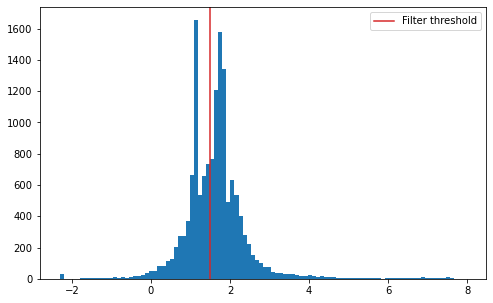

In [5]:
threshold = 1.5

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df.max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [6]:
print("Percent genes removed:", (gene_exp_df.max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df.max() > threshold)
gene_exp_df = gene_exp_df.loc[:, gene_filter]
gene_exp_df

Percent genes removed: 41.94212042243862


,NOC2L,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,CPTP,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGAGGTTAT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.774310,-2.302585,-2.302585,-0.774310,-2.302585,...,4.270848,2.486049,3.379045,4.186710,2.626032,3.128704,2.249876,2.771648,2.455537,3.438745
KMA1_AAACCTGCATTCCTCG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,4.418082,2.492344,3.825994,4.506088,3.035399,3.086452,1.713763,2.864449,2.293510,3.554742
KMA1_AAACCTGGTCCGTGAC,-2.302585,-2.302585,0.399832,-2.302585,-2.302585,0.399832,-2.302585,-2.302585,-2.302585,0.399832,...,3.995838,1.452719,3.167867,3.552182,2.535613,2.535613,1.954144,2.418820,1.734536,3.378374
KMA1_AAACCTGGTTGTACAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.225742,0.225742,0.225742,-2.302585,-2.302585,...,3.324246,1.269692,2.100808,3.037764,1.269692,1.269692,0.225742,0.878175,1.269692,2.232808
KMA1_AAACCTGTCCTGCAGG,-2.302585,-2.302585,0.018975,-2.302585,-2.302585,-2.302585,-2.302585,0.018975,-2.302585,-2.302585,...,3.415500,1.546665,2.695066,2.865850,1.328831,2.229107,1.328831,2.008650,1.049936,1.725431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TTCTCAAGTTGGTAAA,-2.302585,-2.302585,0.268386,-2.302585,-2.302585,0.268386,-2.302585,-2.302585,-2.302585,-2.302585,...,2.499674,0.268386,1.908533,1.711152,0.922553,0.648034,0.648034,1.314679,-0.351082,1.814704
KMA7_TTCTTAGCATCCGCGA,-0.813153,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-1.302951,-1.302951,-1.302951,...,1.721931,0.498080,1.212788,1.105055,0.263979,0.498080,-0.813153,0.498080,0.263979,0.917970
KMA7_TTGCGTCCACCAGCAC,-0.310375,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.330759,0.968005,2.915714,3.044269,2.325398,2.261511,2.261511,2.040969,0.312138,2.641182


Differentially expressed genes, by cluster

In [7]:
gene_exp_adata = sc.AnnData(gene_exp_df.iloc[:, :-1], 
                            obs=metadata_df[['diisco_cluster']].astype('str'))
sc.tl.rank_genes_groups(gene_exp_adata, groupby='diisco_cluster', method='wilcoxon', key_added='wilcoxon')

In [8]:
cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group="0", key='wilcoxon')
top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & (cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,GZMH,101.288528,NaN,0.0,0.0
1,CD3E,94.844521,NaN,0.0,0.0
2,IL32,93.785515,NaN,0.0,0.0
3,CD8A,92.856873,NaN,0.0,0.0
4,CD3D,91.830696,NaN,0.0,0.0
5,CCL5,91.453331,NaN,0.0,0.0
6,CD3G,89.113014,NaN,0.0,0.0
7,CD52,88.951927,NaN,0.0,0.0
8,CD8B,86.566391,NaN,0.0,0.0
9,B2M,84.882027,1.700652,0.0,0.0


In [9]:
cluster_to_degs = dict()
writer = pd.ExcelWriter("data/AML/DEGs/cluster_DEGs.xlsx", engine="xlsxwriter")
clusters = sorted(metadata_df['diisco_cluster'].unique())
for cluster in clusters:
    cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group=str(cluster), key='wilcoxon')
    top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & 
                              (cluster_deg_df['scores'] >= 0)]
    cluster_to_degs[cluster] = {
        deg['names']: deg['pvals_adj']
        for index, deg in top_degs.iterrows()
    }
    top_degs.to_excel(writer, sheet_name=f'Cluster {cluster}', index=False)
writer.close()

Load receptor-ligand pairs from Omnipath DB

In [10]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
# rl_pairs.to_csv('data/RL_pairs/Omnipath_RL_pairs.csv', index=False)
# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
17,Q9H2A7,O00574,CXCL16,CXCR6,True,True,False,True,True,False,20,Baccin2019:11017100;Baccin2019:11290797;Baccin...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,11017100;11290797;14625285;22633458,4,32,20
21,P01579,P15260,IFNG,IFNGR1,True,True,False,True,True,False,58,Baccin2019:10811850;Baccin2019:10986460;Baccin...,Baccin2019;BioGRID;CellCall;CellTalkDB;DIP;DLR...,10811850;10860730;10986460;11250200;12165521;1...,27,33,23
23,P49771,P36888,FLT3LG,FLT3,True,True,False,True,True,False,26,Baccin2019:15147956;Baccin2019:7505204;Baccin2...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10080542;12681969;15147956;15618475;19830725;2...,9,31,21
39,O43557,P36941,TNFSF14,LTBR,True,True,False,True,True,False,22,Baccin2019:10318773;Baccin2019:10799510;Baccin...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10318773;10799510;11239407;12571250;26977880;9...,7,36,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,P36955,Q9GZT5,SERPINF1,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
7968,Q8N474,Q9GZT5,SFRP1,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
7971,P22692,Q9GZT5,IGFBP4,WNT10A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
8322,P09486,Q9GZP0,SPARC,PDGFD,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1


Filter gene expressions to RL genes only

In [11]:
all_rl_genes = set(pd.concat([rl_pairs['source_genesymbol'], rl_pairs['target_genesymbol']]))

gene_exp_df = gene_exp_df.loc[:, gene_exp_df.columns.isin(all_rl_genes)]
gene_exp_df

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGAGGTTAT,-0.774310,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.644539,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACCTGCATTCCTCG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.173921,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACCTGGTCCGTGAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,0.399832,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.399832,-2.302585
KMA1_AAACCTGGTTGTACAC,-2.302585,-2.302585,-2.302585,-2.302585,0.225742,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.948694,-2.302585,-2.302585,-2.302585,0.225742,-2.302585
KMA1_AAACCTGTCCTGCAGG,0.018975,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.328831,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.661818,-2.302585,-2.302585,-2.302585,0.018975,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TTCTCAAGTTGGTAAA,-0.351082,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.137715,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.922553,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTCTTAGCATCCGCGA,-1.302951,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-0.813153,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTGCGTCCACCAGCAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.641978,-2.302585,-2.302585,...,-2.302585,-2.302585,0.312138,-2.302585,0.692905,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


## Responders

In [12]:
gene_exp_responders_df = gene_exp_df[metadata_df['response'] == 'RESPONDER']
metadata_responders_df = metadata_df[metadata_df['response'] == 'RESPONDER']
gene_exp_responders_df

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AAACCTGAGGAGCGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.194858,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAACGGGGTTCGAATC,0.247318,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.247318,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.900638,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAAGCAATCCAGAGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.858084,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-0.159138,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_AAATGCCTCCTCAACC,-2.302585,-0.275980,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.730677,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.275980,-2.302585
KMA1_AACCATGTCTTGAGAC,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.665437,-2.302585,-2.302585,...,-2.302585,0.022417,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TTTGGTTTCCCTAACC,-2.302585,-2.302585,-2.302585,0.004443,0.004443,-2.302585,-2.302585,-0.593797,-2.302585,0.646530,...,-0.593797,-0.593797,-2.302585,-2.302585,1.427925,-2.302585,-2.302585,-2.302585,0.004443,-2.302585
KMA7_TTTGGTTTCCTTTCGG,-2.302585,-2.302585,-2.302585,1.451637,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.781639,...,-2.302585,-2.302585,-2.302585,-2.302585,0.781639,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTTGTCAGTTAAGTAG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.580592,-2.302585,0.580592,...,-2.302585,0.580592,-2.302585,-2.302585,1.924013,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [13]:
X_test = np.load('data/AML/run_3_X_R.npy')
X_test_pre_500_days = (X_test <= 500).flatten()
X_test = X_test[X_test_pre_500_days]

y_preds = np.load('data/AML/run_3_y_preds_R.npy')[X_test_pre_500_days]

W_samples_predict = np.load('data/AML/run_3_W_samples_predict_R.npy')
W = W_samples_predict.mean(axis=0)[X_test_pre_500_days]

clusters_of_interest = {
    '0': 'T cell',
    '1': 'NK cell',
    '13': 'NK cell',
    '2': 'T cell',
    '20': 'B cell',
    '26': 'T cell',
    '3': 'B cell',
    '40': 'T cell',
    '5': 'T cell',
    'MC1': 'Myeloid',
    'MC1_leuk': 'AML',
    'MC2': 'Myeloid',
    'MC3': 'Myeloid',
    'MC4': 'Myeloid',
    'MC7': 'Myeloid'
}

Text(0.5, 1.0, '$\\hat{W}_{avg}$ (300 days post DLI)')

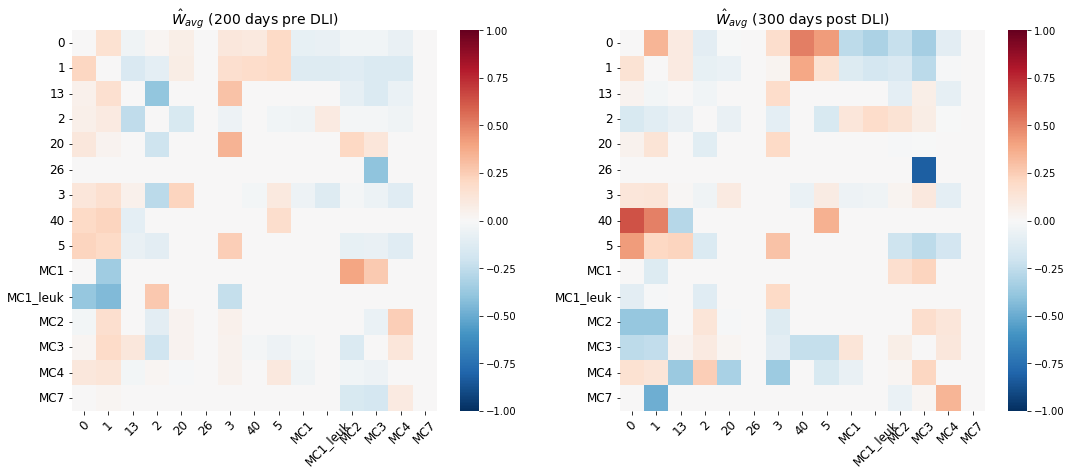

In [14]:
vmin = -1
vmax = 1

X_200_days_pre_dli_index = np.where(X_test > -200)[0][0]
X_post_dli_index = np.where(X_test > 0)[0][0]
X_300_days_post_dli_index = np.where(X_test > 300)[0][0]
X_post_dli_index

W_pre_dli = W[X_200_days_pre_dli_index:X_post_dli_index]
W_post_dli = W[X_post_dli_index:X_300_days_post_dli_index]
W_pre_dli_avg_over_time = np.mean(W_pre_dli, axis=0)
W_post_dli_avg_over_time = np.mean(W_post_dli, axis=0)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
ax = sns.heatmap(W_pre_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (200 days pre DLI)', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.heatmap(W_post_dli_avg_over_time, cmap="RdBu_r", annot=False, 
                 fmt='.2f', vmin=vmin, vmax=vmax)
ax.set_yticklabels(clusters_of_interest, fontsize=12)
ax.set_xticklabels(clusters_of_interest, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$ (300 days post DLI)', fontsize=14)

In [35]:
source_cluster = '0'
target_cluster = 'MC1_leuk'

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)

Text(0.5, 1.0, 'Cluster 0 --> MC1_leuk interaction (abs val)')

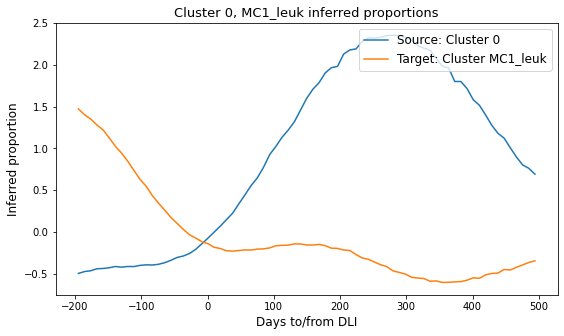

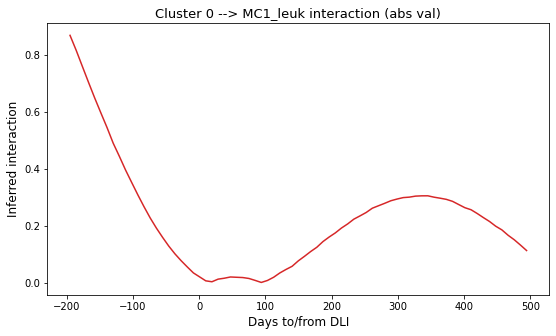

In [36]:
plt.figure(figsize=(9, 5))
plt.plot(X_test, y_preds[:, source_cluster_index], label=f'Source: Cluster {source_cluster}')
plt.plot(X_test, y_preds[:, target_cluster_index], label=f'Target: Cluster {target_cluster}')
plt.ylabel('Inferred proportion', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster}, {target_cluster} inferred proportions', fontsize=13)
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(9, 5))
plt.plot(X_test, np.abs(W[:, target_cluster_index, source_cluster_index]), color='tab:red')
plt.ylabel('Inferred interaction', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)', fontsize=13)

In [37]:
source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
source_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA1_AACTCAGTCGGCATCG,1.260805,-2.302585,-2.302585,-2.302585,0.869411,-2.302585,-2.302585,2.444738,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.939679,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_CCTACACGTCAGATAA,-0.468295,-2.302585,-2.302585,-0.468295,-2.302585,-2.302585,-2.302585,1.575802,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.517725,-2.302585,-2.302585,-2.302585,0.790399,-2.302585
KMA1_CGTAGCGAGGCATGTG,1.468329,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.468329,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,1.468329,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA1_CTCTGGTAGCTAGCCC,0.719159,-0.286480,-2.302585,0.337760,-0.286480,-2.302585,-2.302585,1.538225,-2.302585,-2.302585,...,-0.286480,-2.302585,-2.302585,-2.302585,0.719159,-2.302585,-2.302585,0.337760,-2.302585,-2.302585
KMA1_CTGAAGTGTAAGAGAG,0.655727,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.540379,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.655727,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA7_TCTGGAAGTACTTCTT,0.027472,-2.302585,-2.302585,-2.302585,1.059026,-2.302585,-2.302585,1.734681,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.027472,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAACTCAGAGGGATA,0.013971,-2.302585,-2.302585,-2.302585,0.013971,-2.302585,-2.302585,2.223617,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.656555,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA7_TTAGTTCCAAGTAGTA,0.480523,-2.302585,-2.302585,-0.501470,-2.302585,-2.302585,-2.302585,2.102943,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,0.752622,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [38]:
target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
target_cluster_cells

,TNFRSF14,TNFRSF25,TNFRSF9,AGTRAP,TNFRSF1B,C1QA,C1QB,CD52,TMEM222,PTAFR,...,IFNAR1,IFNGR2,ICOSLG,TRPM2,ITGB2,COL18A1,COL6A1,COL6A2,DIP2A,S100B
index,,,,,,,,,,,,,,,,,,,,,
KMA3_AAACCTGGTAACGCGA,-2.302585,-2.302585,-2.302585,-2.302585,-0.987290,-2.302585,-2.302585,-0.987290,-2.302585,-2.302585,...,-2.302585,0.174239,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.987290,-2.302585
KMA3_AAACCTGTCGGATGTT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-0.155954,-2.302585,-2.302585,-0.155954,-2.302585,-2.302585,-2.302585,-0.155954,-2.302585
KMA3_AAACGGGCATCACCCT,-2.302585,-2.302585,-2.302585,-2.302585,-1.246649,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-0.744582,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA3_AAACGGGGTCTTGCGG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA3_AAAGATGCACAAGTAA,-2.302585,-2.302585,-2.302585,-2.302585,-0.868723,-2.302585,-2.302585,0.056816,-0.868723,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMA5_TCAGGTATCCAGGGCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.208592,-2.302585
KMA5_TCGAGGCCATGTCCTC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
KMA5_TGGCTGGCATCGGAAG,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-0.283236,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


Filter down to differentially-expressed RL genes per cluster

In [39]:
source_cluster_degs = cluster_to_degs[source_cluster]
target_cluster_degs = cluster_to_degs[target_cluster]

Sliding window mean of ligand and receptor expression at DLI time points

In [40]:
min_exp_threshold = -5
sliding_window_length = 2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_receptor_corrs_with_interaction = []
for index, rl_pair in tqdm_notebook(list(rl_pairs.iterrows())):
    ligand_gene = rl_pair['source_genesymbol']
    receptor_gene = rl_pair['target_genesymbol']
    # Filter to differentially-expressed RL genes
    if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
        continue
    # Model for ligand gene expression
    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(ligand_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    # Model for receptor gene expression
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
    days_to_dli = sorted(receptor_days_to_dli.unique())
    if len(days_to_dli) < sliding_window_length: continue
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    # Correlations b/w ligand/receptor gene expression and inferred interaction
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])
    ligand_receptor_corrs_with_interaction.append({
        'Ligand': ligand_gene,
        'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
        'Ligand DEG pval': source_cluster_degs[ligand_gene],
        'Receptor': receptor_gene,
        'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
        'Receptor DEG pval': target_cluster_degs[receptor_gene],
        'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
    })
    

  0%|          | 0/1159 [00:00<?, ?it/s]

In [42]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.sort_values('Ligand-interaction correlation', ascending=False)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.head(25)

,Ligand,Ligand-interaction correlation,Ligand DEG pval,Receptor,Receptor-interaction correlation,Receptor DEG pval,Avg ligand/receptor-interaction correlation
0,B2M,0.887876,0.000000e+00,TFRC,0.983089,2.362763e-19,0.935482
1,HLA-B,0.771020,0.000000e+00,CANX,0.985189,5.446096e-44,0.878105
2,HLA-A,0.717451,0.000000e+00,APLP2,-0.988056,3.400556e-48,-0.135303
3,RPS27A,0.509054,3.179311e-73,SMAD3,0.985243,8.581421e-09,0.747148
4,RPS27A,0.509054,3.179311e-73,TGFBR1,0.987800,1.304294e-09,0.748427
5,FLT3LG,0.504135,3.849296e-68,FLT3,-0.988522,2.649331e-293,-0.242194
6,CALM1,0.501443,0.000000e+00,KCNN4,-0.987503,1.028019e-04,-0.243030
7,CALM1,0.501443,0.000000e+00,KCNQ5,0.990736,1.727131e-07,0.746089
8,CALM1,0.501443,0.000000e+00,ABCA1,0.986802,2.527471e-09,0.744122
9,CALM1,0.501443,0.000000e+00,MYLK,-0.989579,7.906620e-03,-0.244068


In [43]:
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.head(30)
ligand_receptor_corrs_with_interaction_df.to_excel(f'data/AML/run_3/all_samples/{source_cluster} --> {target_cluster}.xlsx', 
                                                    sheet_name='R',
                                                    index=False)

In [44]:
ligand_gene = 'B2M'
receptor_gene = 'TFRC'

min_exp_threshold = -5
sliding_window_length = 2

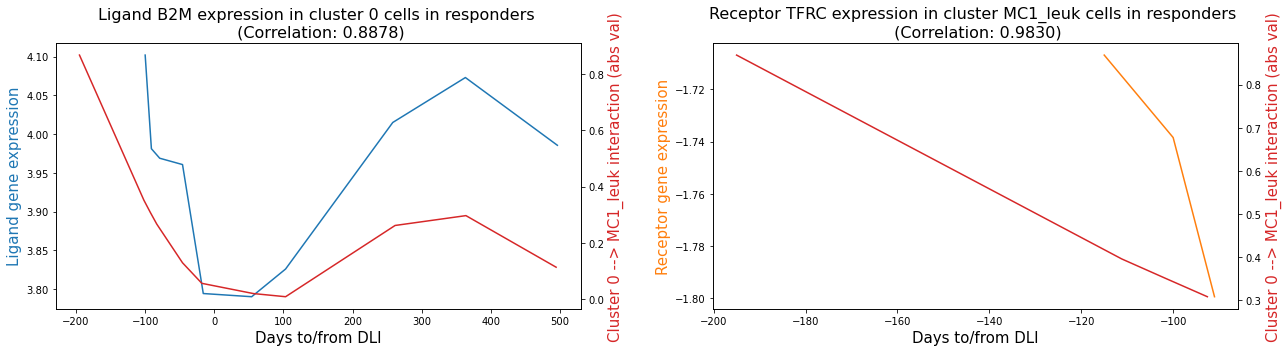

In [45]:
min_exp_threshold = -5

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
# ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
# ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('figures/AML_paper/example_top_RL_pair_R.eps')

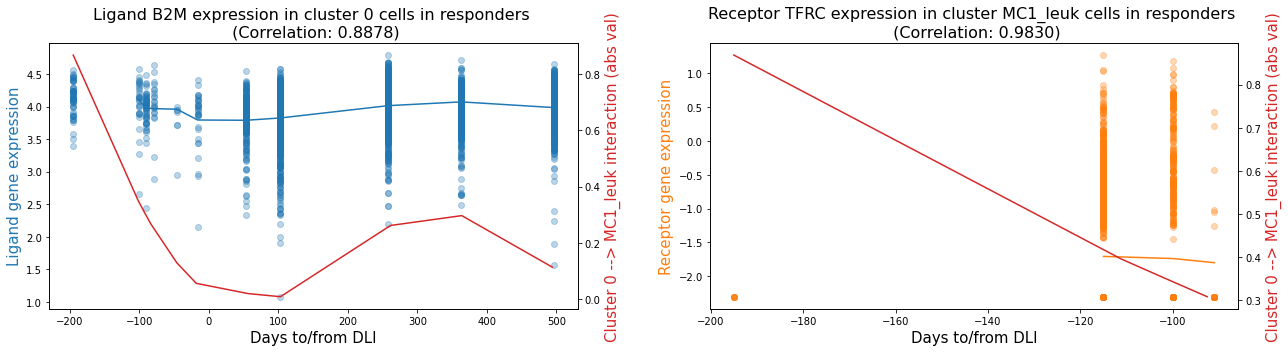

In [46]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(ligand_days_to_dli.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']
days_to_dli = sorted(receptor_days_to_dli.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Days to/from DLI', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('figures/AML_paper/example_top_RL_pair_R.eps')

[Text(0.5, 0, '-195'), Text(1.5, 0, '-100'), Text(2.5, 0, '-91')]

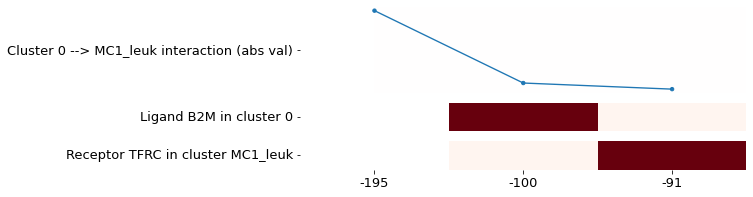

In [47]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']

days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)

sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(days_to_dli)
})
receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)

rl_expression = pd.DataFrame(np.vstack([sliding_window_mean_ligand_gene_exp, 
                                        sliding_window_mean_receptor_gene_exp]), 
                             columns=days_to_dli)
rl_expression.index = [f'Ligand {ligand_gene} in cluster {source_cluster}', 
                       f'Receptor {receptor_gene} in cluster {target_cluster}']

plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 
plt.subplot(gs[0])
g = sns.heatmap([np.zeros_like(source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates])], 
                yticklabels=[f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)'],
                cmap='bwr', vmin=-1, center=0, vmax=1, cbar=False)
ax2 = plt.twinx()
sns.pointplot(x=sliding_window_mean_ligand_gene_exp.index,
             y=source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], 
             ax=ax2, scale=0.5)
plt.axis('off')
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels([], size = 13)
g.set_xticks([])
plt.subplot(gs[1])
g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar=False)
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels([], size = 13)
g.set_xticks([])
plt.subplot(gs[2])
g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar=False)
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=0)

Ligand: B2M
Receptor: TFRC
Ligand-interaction correlation: 0.8878
Receptor-interaction correlation: 0.9830
Avg ligand/receptor-interaction correlation: 0.9354


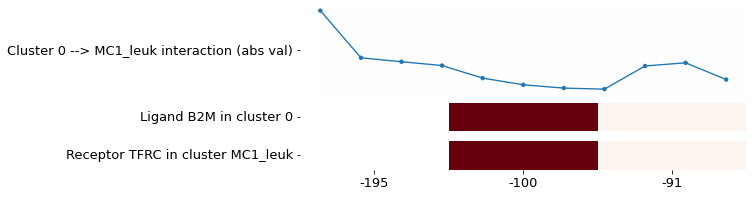

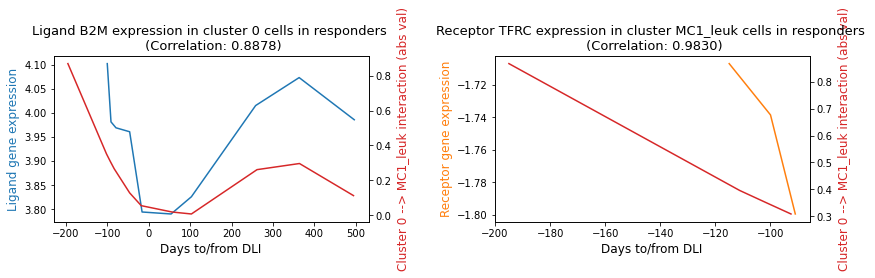



Ligand: HLA-B
Receptor: CANX
Ligand-interaction correlation: 0.7710
Receptor-interaction correlation: 0.9851
Avg ligand/receptor-interaction correlation: 0.8781


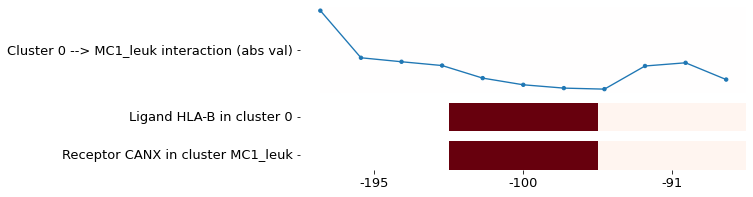

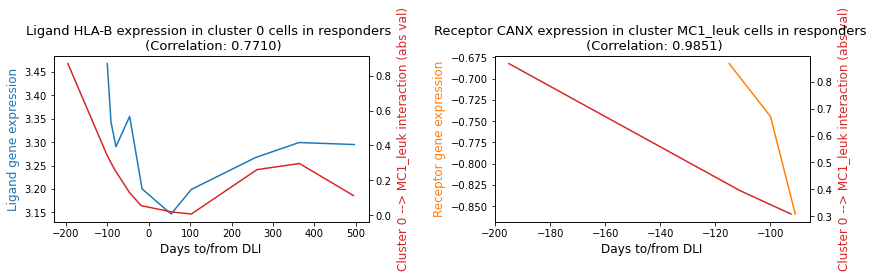



Ligand: HLA-A
Receptor: APLP2
Ligand-interaction correlation: 0.7174
Receptor-interaction correlation: -0.988
Avg ligand/receptor-interaction correlation: -0.135


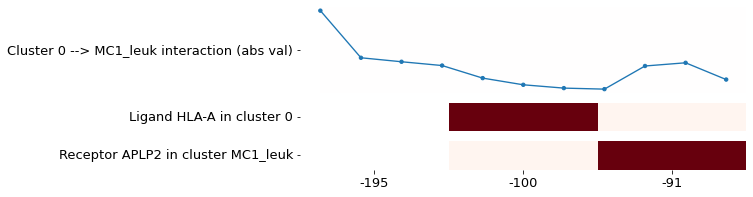

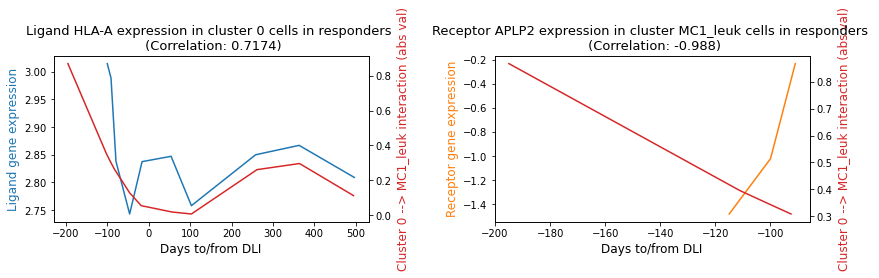



Ligand: RPS27A
Receptor: SMAD3
Ligand-interaction correlation: 0.5090
Receptor-interaction correlation: 0.9852
Avg ligand/receptor-interaction correlation: 0.7471


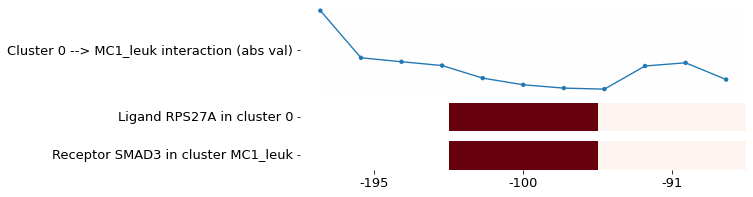

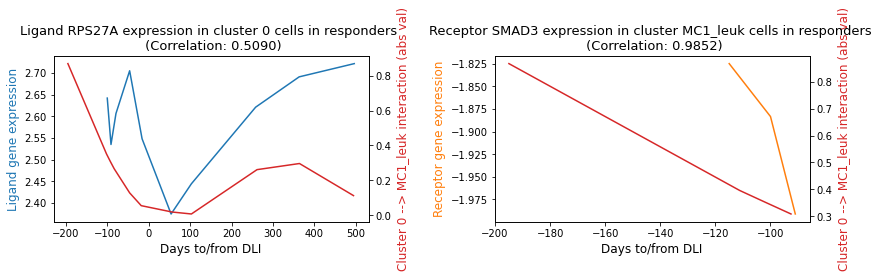



Ligand: RPS27A
Receptor: TGFBR1
Ligand-interaction correlation: 0.5090
Receptor-interaction correlation: 0.9878
Avg ligand/receptor-interaction correlation: 0.7484


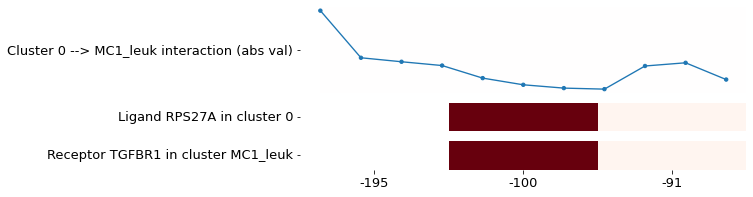

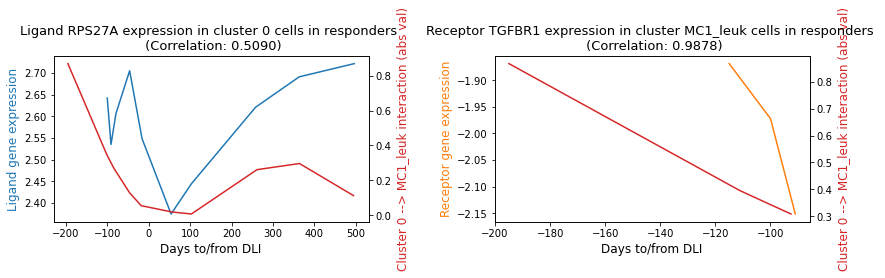



Ligand: FLT3LG
Receptor: FLT3
Ligand-interaction correlation: 0.5041
Receptor-interaction correlation: -0.988
Avg ligand/receptor-interaction correlation: -0.242


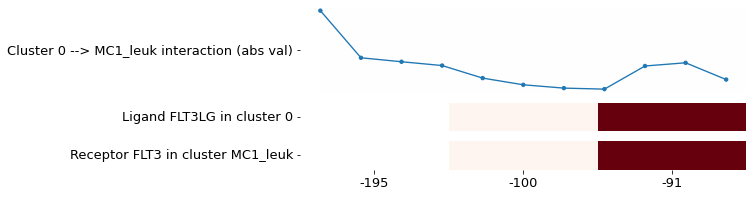

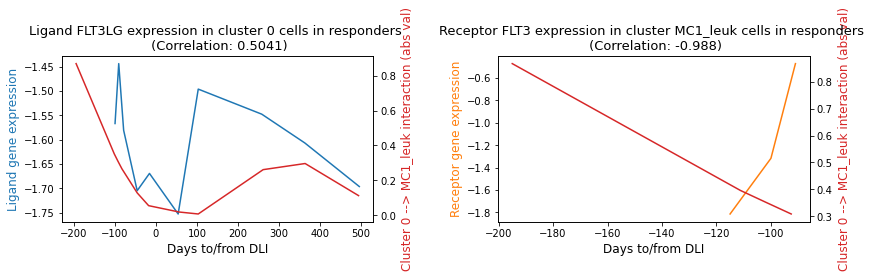



Ligand: CALM1
Receptor: KCNN4
Ligand-interaction correlation: 0.5014
Receptor-interaction correlation: -0.987
Avg ligand/receptor-interaction correlation: -0.243


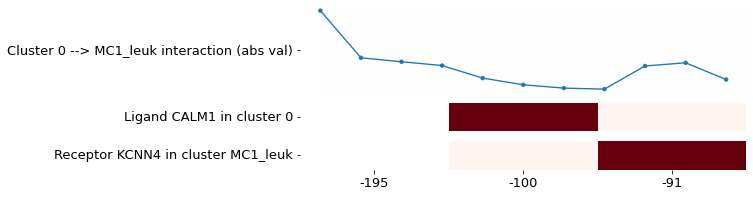

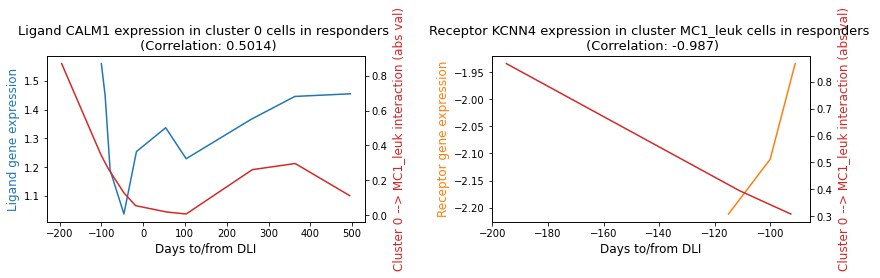



Ligand: CALM1
Receptor: KCNQ5
Ligand-interaction correlation: 0.5014
Receptor-interaction correlation: 0.9907
Avg ligand/receptor-interaction correlation: 0.7460


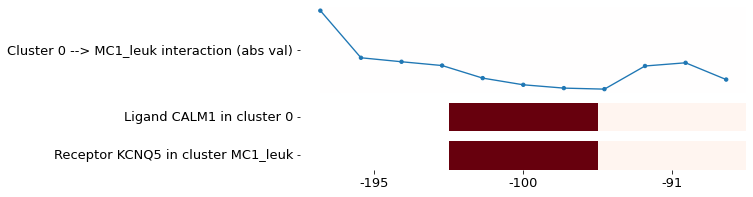

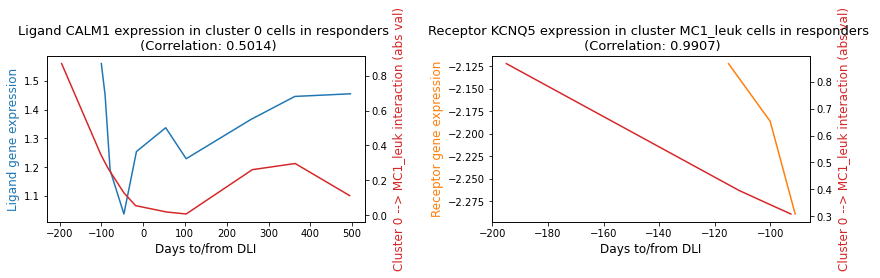



Ligand: CALM1
Receptor: ABCA1
Ligand-interaction correlation: 0.5014
Receptor-interaction correlation: 0.9868
Avg ligand/receptor-interaction correlation: 0.7441


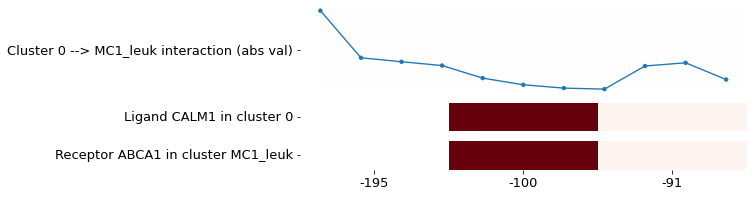

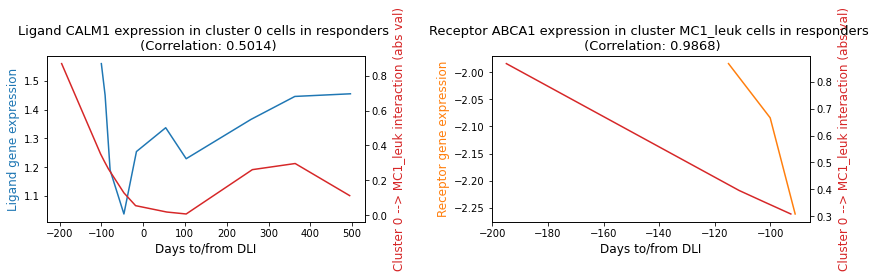



Ligand: CALM1
Receptor: MYLK
Ligand-interaction correlation: 0.5014
Receptor-interaction correlation: -0.989
Avg ligand/receptor-interaction correlation: -0.244


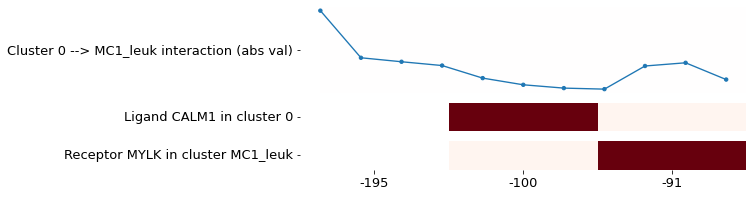

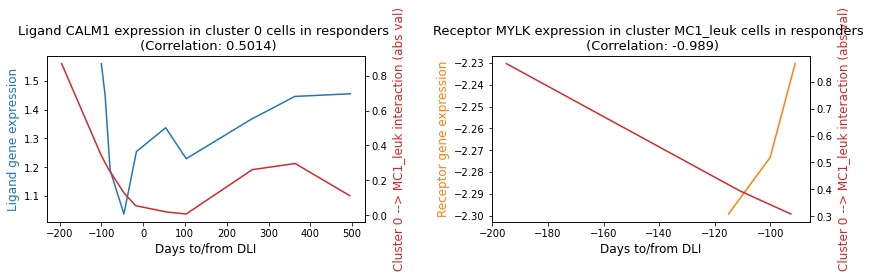



Ligand: FASLG
Receptor: TNFRSF10B
Ligand-interaction correlation: 0.4913
Receptor-interaction correlation: 0.9895
Avg ligand/receptor-interaction correlation: 0.7404


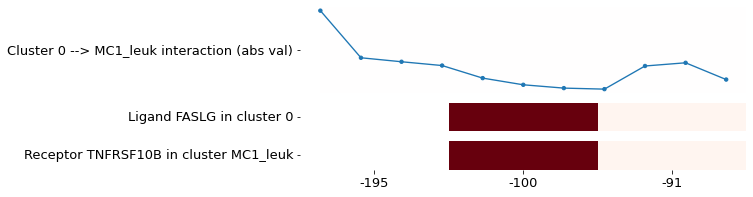

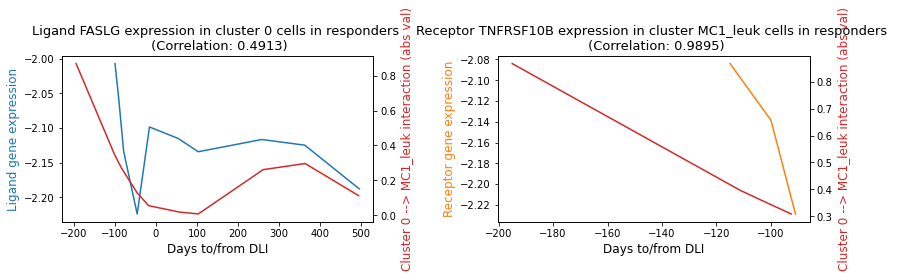



Ligand: FASLG
Receptor: TNFRSF1A
Ligand-interaction correlation: 0.4913
Receptor-interaction correlation: -0.989
Avg ligand/receptor-interaction correlation: -0.248


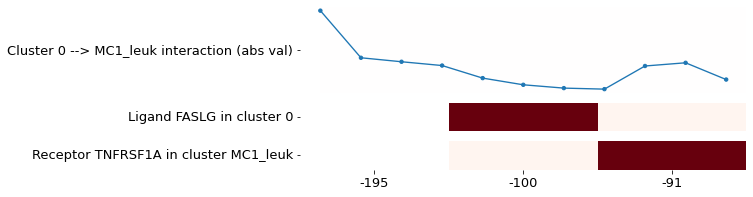

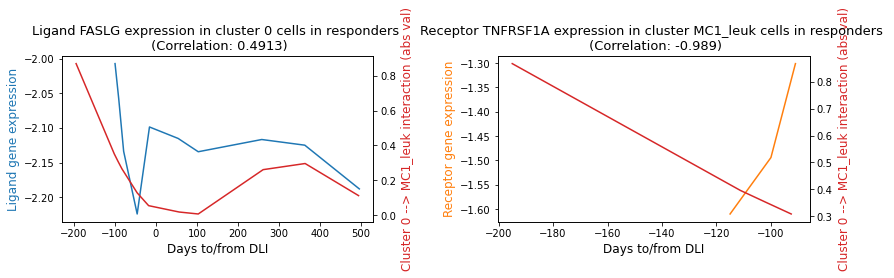



Ligand: TNFSF14
Receptor: LTBR
Ligand-interaction correlation: 0.4497
Receptor-interaction correlation: -0.983
Avg ligand/receptor-interaction correlation: -0.266


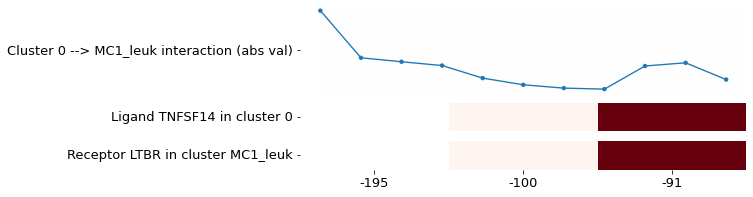

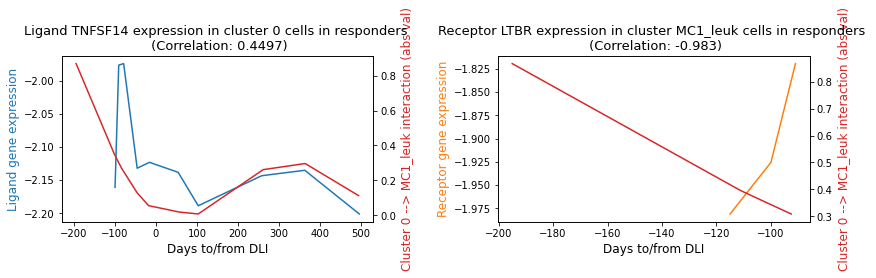



Ligand: TGFBR1
Receptor: ENG
Ligand-interaction correlation: 0.4251
Receptor-interaction correlation: -0.988
Avg ligand/receptor-interaction correlation: -0.281


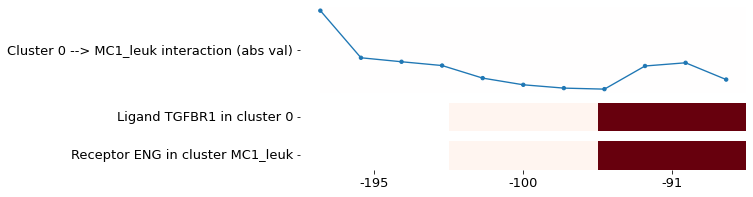

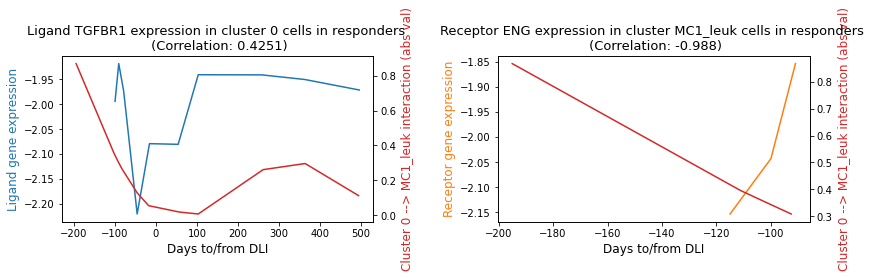



Ligand: COL6A2
Receptor: CD44
Ligand-interaction correlation: 0.3622
Receptor-interaction correlation: 0.8479
Avg ligand/receptor-interaction correlation: 0.6051


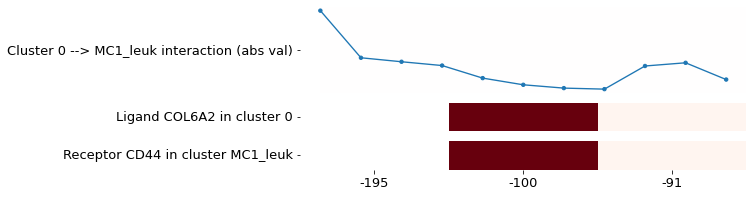

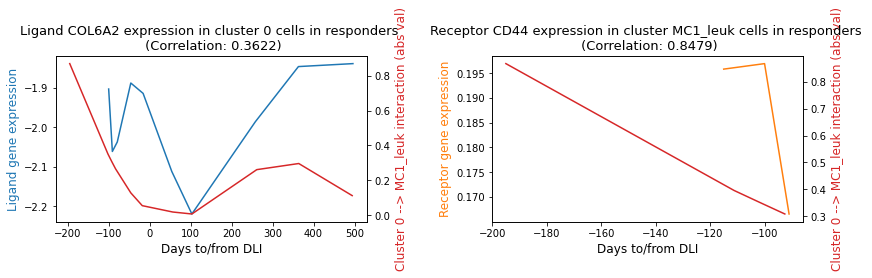



Ligand: UBA52
Receptor: SMAD3
Ligand-interaction correlation: 0.3045
Receptor-interaction correlation: 0.9852
Avg ligand/receptor-interaction correlation: 0.6449


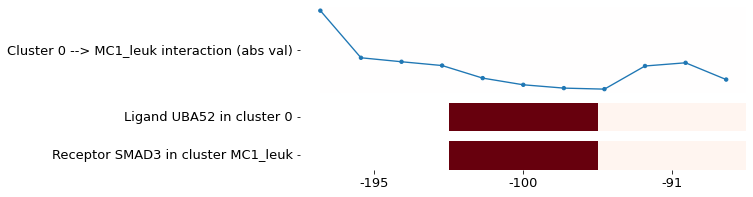

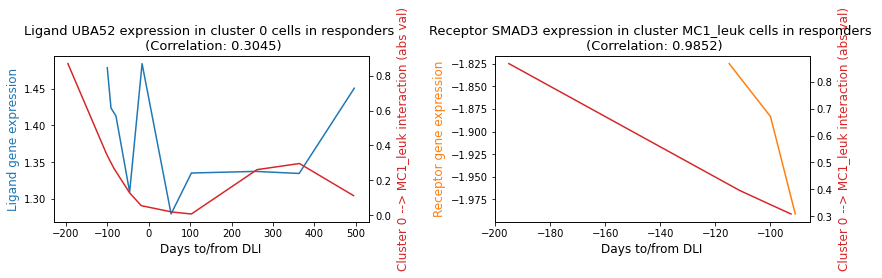



Ligand: UBA52
Receptor: TGFBR1
Ligand-interaction correlation: 0.3045
Receptor-interaction correlation: 0.9878
Avg ligand/receptor-interaction correlation: 0.6461


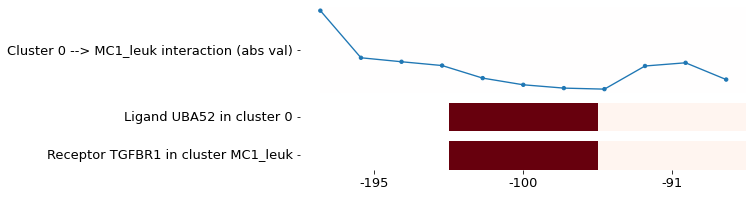

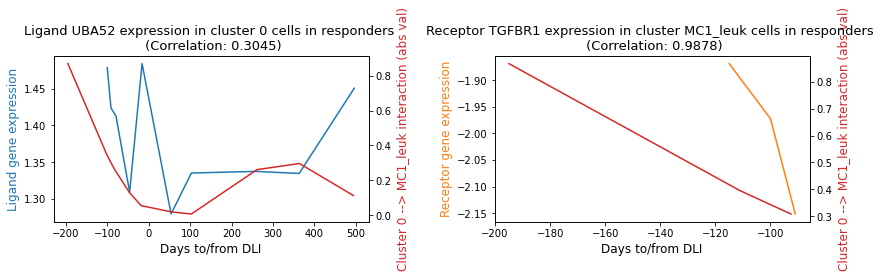



Ligand: UBA52
Receptor: NOTCH1
Ligand-interaction correlation: 0.3045
Receptor-interaction correlation: 0.9873
Avg ligand/receptor-interaction correlation: 0.6459


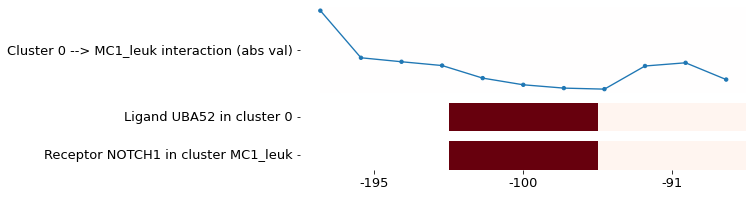

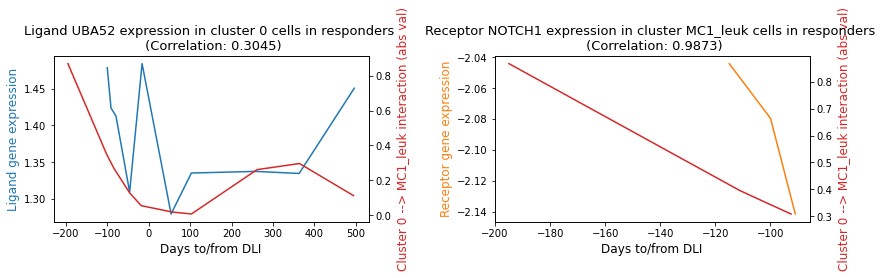



Ligand: ANXA2
Receptor: TLR2
Ligand-interaction correlation: 0.2275
Receptor-interaction correlation: -0.986
Avg ligand/receptor-interaction correlation: -0.379


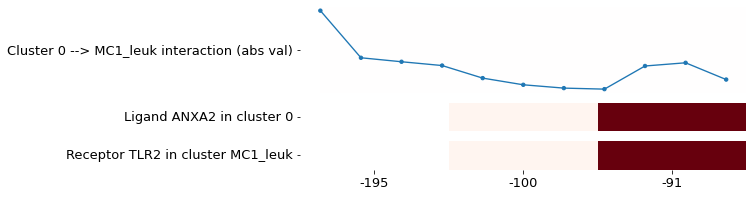

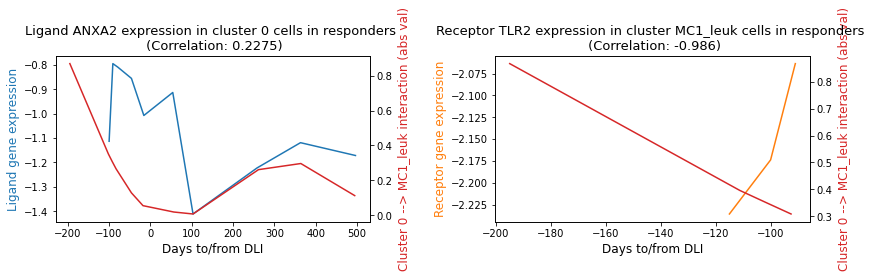



Ligand: ANXA2
Receptor: DYSF
Ligand-interaction correlation: 0.2275
Receptor-interaction correlation: 0.9891
Avg ligand/receptor-interaction correlation: 0.6083


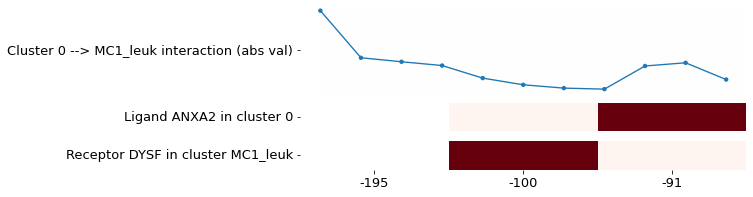

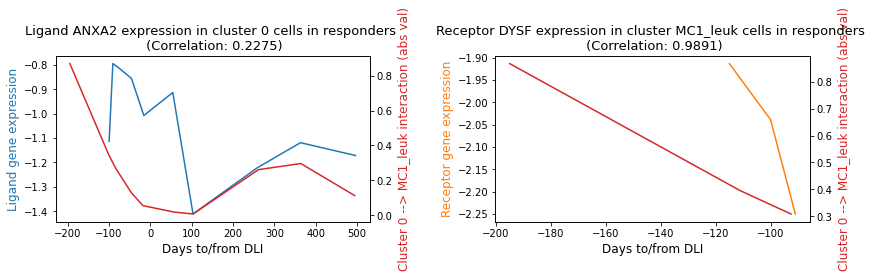



Ligand: ADRB2
Receptor: PRNP
Ligand-interaction correlation: 0.2101
Receptor-interaction correlation: 0.9873
Avg ligand/receptor-interaction correlation: 0.5987


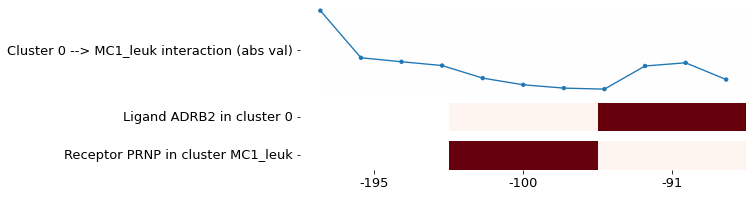

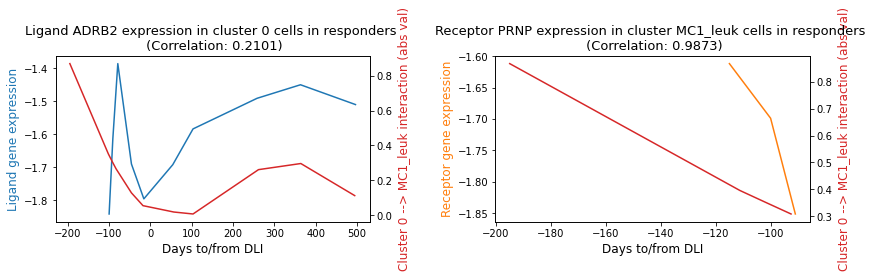



Ligand: ADRB2
Receptor: MGLL
Ligand-interaction correlation: 0.2101
Receptor-interaction correlation: -0.988
Avg ligand/receptor-interaction correlation: -0.389


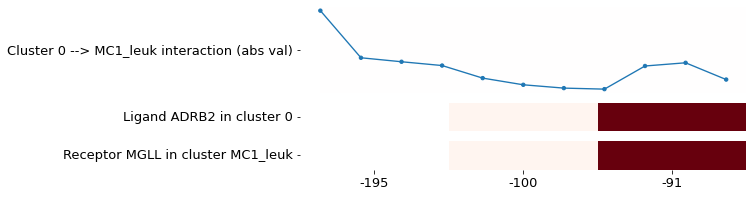

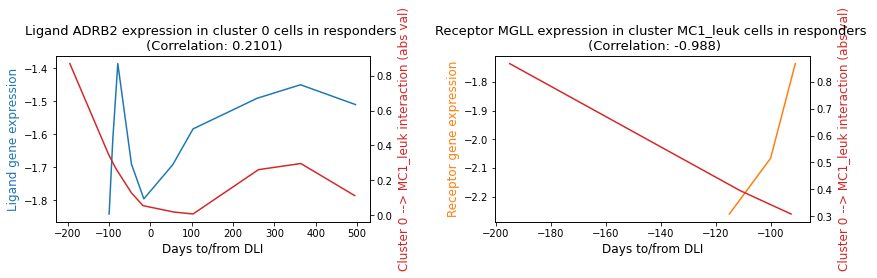



Ligand: ADRB2
Receptor: VAPA
Ligand-interaction correlation: 0.2101
Receptor-interaction correlation: 0.9862
Avg ligand/receptor-interaction correlation: 0.5981


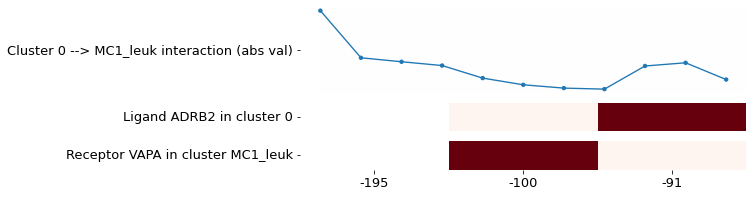

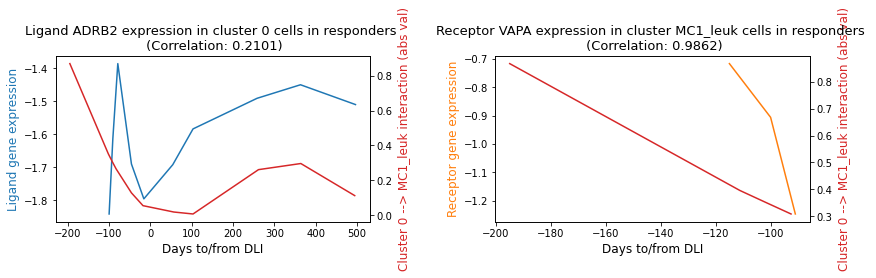



Ligand: CCL4
Receptor: SLC7A1
Ligand-interaction correlation: 0.0854
Receptor-interaction correlation: -0.992
Avg ligand/receptor-interaction correlation: -0.453


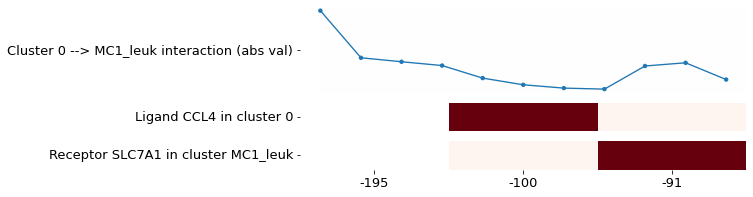

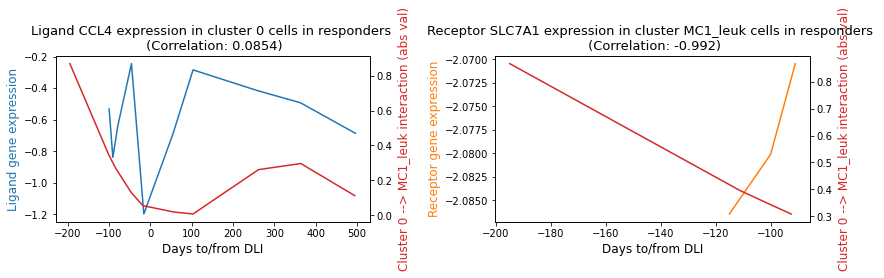



Ligand: GZMA
Receptor: F2R
Ligand-interaction correlation: 0.0581
Receptor-interaction correlation: -0.993
Avg ligand/receptor-interaction correlation: -0.467


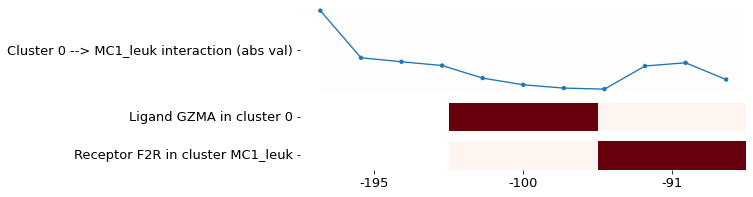

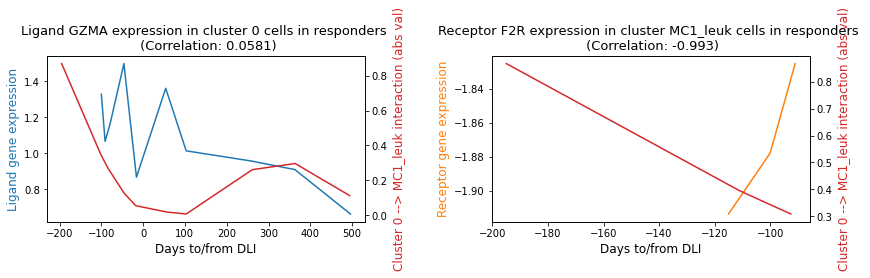



Ligand: CIRBP
Receptor: TREM1
Ligand-interaction correlation: 0.0276
Receptor-interaction correlation: 0.9870
Avg ligand/receptor-interaction correlation: 0.5073


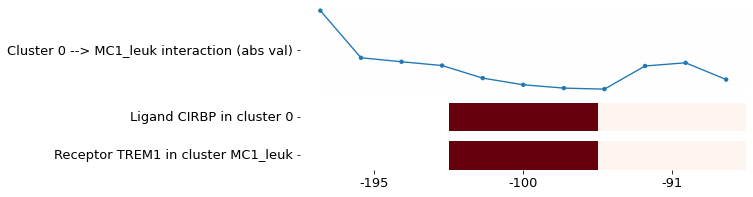

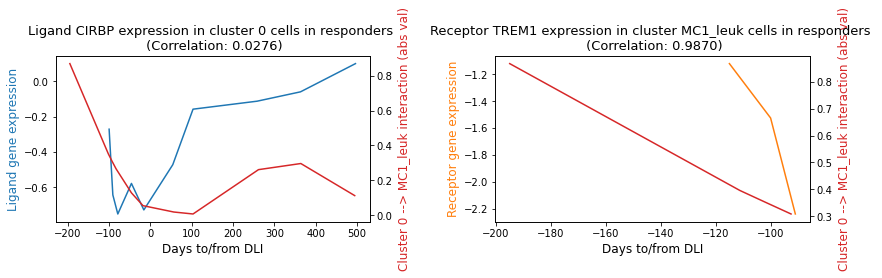



Ligand: GNAI2
Receptor: F2R
Ligand-interaction correlation: 0.0229
Receptor-interaction correlation: -0.993
Avg ligand/receptor-interaction correlation: -0.485


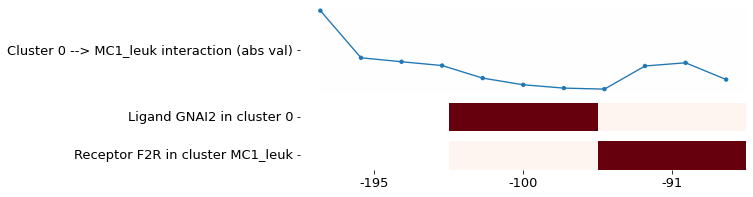

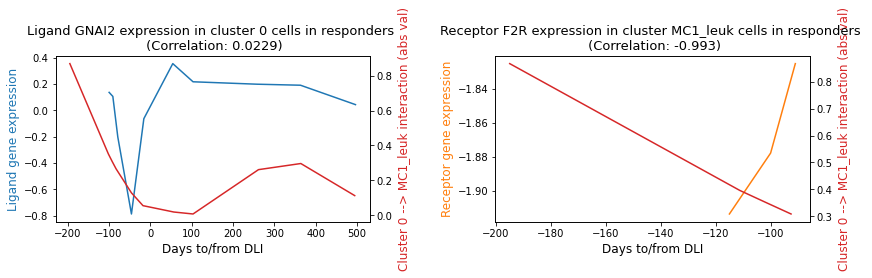



Ligand: CD81
Receptor: KIT
Ligand-interaction correlation: -0.065
Receptor-interaction correlation: -0.980
Avg ligand/receptor-interaction correlation: -0.522


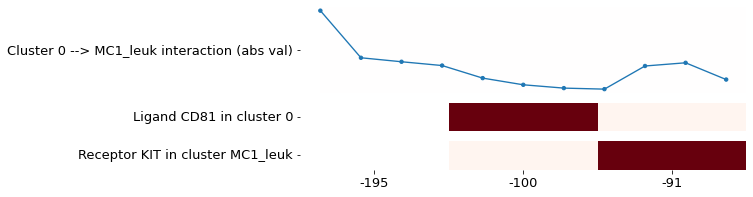

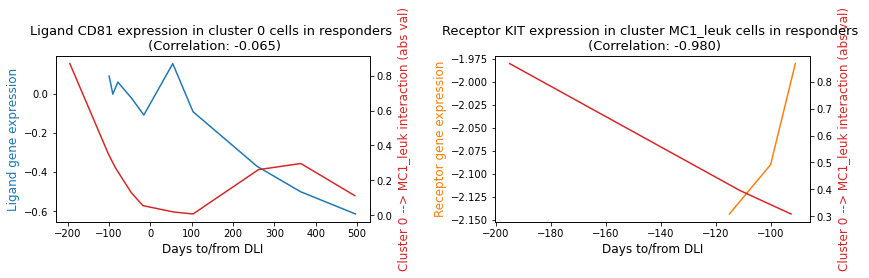



Ligand: ITGB1
Receptor: ENG
Ligand-interaction correlation: -0.094
Receptor-interaction correlation: -0.988
Avg ligand/receptor-interaction correlation: -0.541


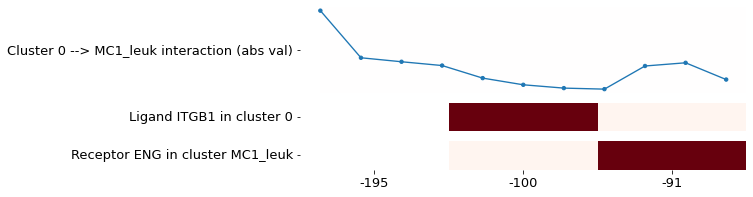

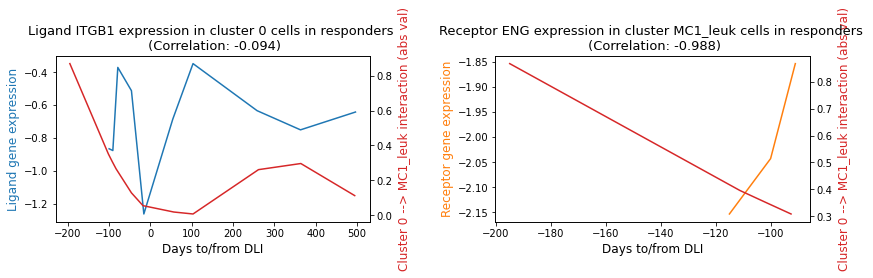



Ligand: ITGB1
Receptor: CD151
Ligand-interaction correlation: -0.094
Receptor-interaction correlation: 0.9887
Avg ligand/receptor-interaction correlation: 0.4473


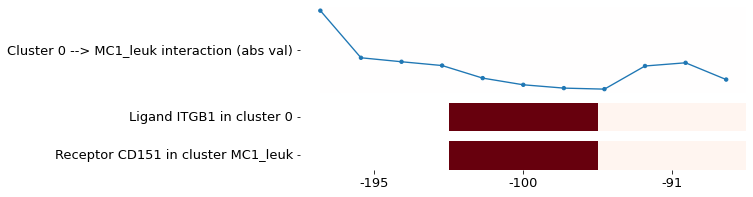

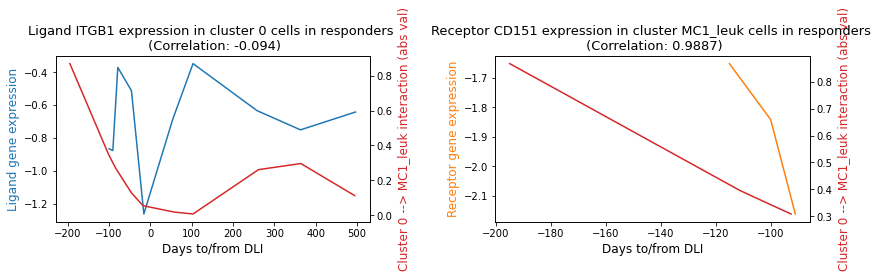

In [48]:
min_exp_threshold = -5
sliding_window_length = 2

source_cluster_index = list(clusters_of_interest).index(source_cluster)
target_cluster_index = list(clusters_of_interest).index(target_cluster)
source_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == source_cluster]
target_cluster_cells = gene_exp_responders_df[metadata_responders_df['diisco_cluster'] == target_cluster]
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

for _, rl_pair in ligand_receptor_corrs_with_interaction_df.iterrows():
    ligand_gene = rl_pair["Ligand"]
    receptor_gene = rl_pair["Receptor"]
    print("Ligand:", ligand_gene)
    print("Receptor:", receptor_gene)

    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_days_to_dli = metadata_responders_df.loc[ligand_gene_exp.index, 'days_to_DLI']
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_days_to_dli = metadata_responders_df.loc[receptor_gene_exp.index, 'days_to_DLI']

    days_to_dli = sorted(ligand_days_to_dli.unique())
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    ligand_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_dli_dates = np.append(ligand_closest_Xs_to_dli_dates, closest_X)
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                          source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates][sliding_window_length-1:])

    days_to_dli = sorted(receptor_days_to_dli.unique())
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_days_to_dli.isin(days_to_dli[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(days_to_dli)
    })
    receptor_closest_Xs_to_dli_dates = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_dli_dates = np.append(receptor_closest_Xs_to_dli_dates, closest_X)
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates][sliding_window_length-1:])

    heatmap_days_to_dli = sorted(set(ligand_days_to_dli.unique()).intersection(receptor_days_to_dli.unique()))
    heatmap_sliding_window_mean_ligand_gene_exp = sliding_window_mean_ligand_gene_exp[heatmap_days_to_dli]
    heatmap_sliding_window_mean_receptor_gene_exp = sliding_window_mean_receptor_gene_exp[heatmap_days_to_dli]
    rl_expression = pd.DataFrame(np.vstack([heatmap_sliding_window_mean_ligand_gene_exp, 
                                            heatmap_sliding_window_mean_receptor_gene_exp]), 
                                 columns=heatmap_days_to_dli)
    rl_expression.index = [f'Ligand {ligand_gene} in cluster {source_cluster}', 
                           f'Receptor {receptor_gene} in cluster {target_cluster}']

    print("Ligand-interaction correlation:", 
          str(ligand_interaction_corr[0, 1])[:6])
    print("Receptor-interaction correlation:", 
          str(receptor_interaction_corr[0, 1])[:6])
    print("Avg ligand/receptor-interaction correlation:", 
          str((ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2)[:6])

    plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 
    plt.subplot(gs[0])
    g = sns.heatmap([np.zeros_like(source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates])], 
                    yticklabels=[f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)'],
                    cmap='bwr', vmin=-1, center=0, vmax=1, cbar=False)
    ax2 = plt.twinx()
    sns.pointplot(x=sliding_window_mean_ligand_gene_exp.index,
                  y=source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], 
                  ax=ax2, scale=0.5)
    plt.axis('off')
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[1])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar=False)
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels([], size = 13)
    g.set_xticks([])
    plt.subplot(gs[2])
    g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar=False)
    g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
    g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=0)
    plt.savefig(f'figures/AML/run_3/top_RL_pairs/all_samples/{source_cluster}->{target_cluster}'\
                f'_{ligand_gene}_{receptor_gene}.eps', bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(12, 3.5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = ax1.twinx()
    ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
             sliding_window_mean_ligand_gene_exp, 
             color='tab:blue')
    ax1.set_ylabel('Ligand gene expression', fontsize=12, color='tab:blue')
    ax2.plot(X_test[ligand_closest_Xs_to_dli_dates], 
             source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_dli_dates], color='tab:red')
    ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
                   fontsize=12, color='tab:red')
    ax1.set_xlabel('Days to/from DLI', fontsize=12)
    plt.title(f'Ligand {ligand_gene} expression in cluster {source_cluster} cells in responders \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
              fontsize=13)

    ax1 = plt.subplot(1, 2, 2)
    ax2 = ax1.twinx()
    ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
             sliding_window_mean_receptor_gene_exp, 
             color='tab:orange')
    ax1.set_ylabel('Receptor gene expression', fontsize=12, color='tab:orange')
    ax2.plot(X_test[receptor_closest_Xs_to_dli_dates], 
             source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_dli_dates], color='tab:red')
    ax2.set_ylabel(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)',
                   fontsize=12, color='tab:red')
    ax1.set_xlabel('Days to/from DLI', fontsize=12)
    plt.title(f'Receptor {receptor_gene} expression in cluster {target_cluster} cells in responders \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
              fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'figures/AML/run_3/top_RL_pairs/all_samples/{source_cluster}->{target_cluster}'\
                f'_{ligand_gene}_{receptor_gene}_.eps', bbox_inches="tight")
    plt.show()

    print()
    print()